In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
features = [
#     'clean_q1_tokenized',
#     'clean_q2_tokenized',
#     'clean_q1_stem',
#     'clean_q2_stem',
#     'clean_q1_pos_tagged',
#     'clean_q2_pos_tagged',
#     'clean_q1_lemmatized',
#     'clean_q2_lemmatized',
    'clean_q1_lemmatized_stem',
    'clean_q2_lemmatized_stem'
]

In [3]:
def read_data(t, features):
    data = pd.read_csv('../input/{}.csv'.format(t))
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)))
    data.fillna(0.0)
    return data

In [4]:
train = read_data('train', features)#[:10000]
test = read_data('test', features)#[:10000]

In [5]:
stems = train.clean_q1_lemmatized_stem.tolist() + train.clean_q2_lemmatized_stem.tolist() + test.clean_q1_lemmatized_stem.tolist() + test.clean_q2_lemmatized_stem.tolist()

uniq_stems = set(' '.join(stem) for stem in stems)
len(uniq_stems)

3677440

In [6]:
from nltk import FreqDist
words = []
for s in uniq_stems:
    words.extend(set(s.lower().split()))
freq = FreqDist(words)

In [7]:
def get_weight(word):
    return 1 - freq[word] / len(uniq_stems)

In [8]:
def sum_weights(words):
    return sum(get_weight(w) for w in words)

def sum_weight_common_words(row):
    q1_stem = set(row.clean_q1_lemmatized_stem)
    q2_stem = set(row.clean_q2_lemmatized_stem)
    common_stem = q1_stem & q2_stem
    if common_stem:
        return sum_weights(common_stem) / (sum_weights(q1_stem) + sum_weights(q2_stem))
    else:
        return 0

In [9]:
train['norm_sum_prob_weight_common_words'] = train.apply(sum_weight_common_words, axis=1)
test['norm_sum_prob_weight_common_words'] = test.apply(sum_weight_common_words, axis=1)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 15.0)

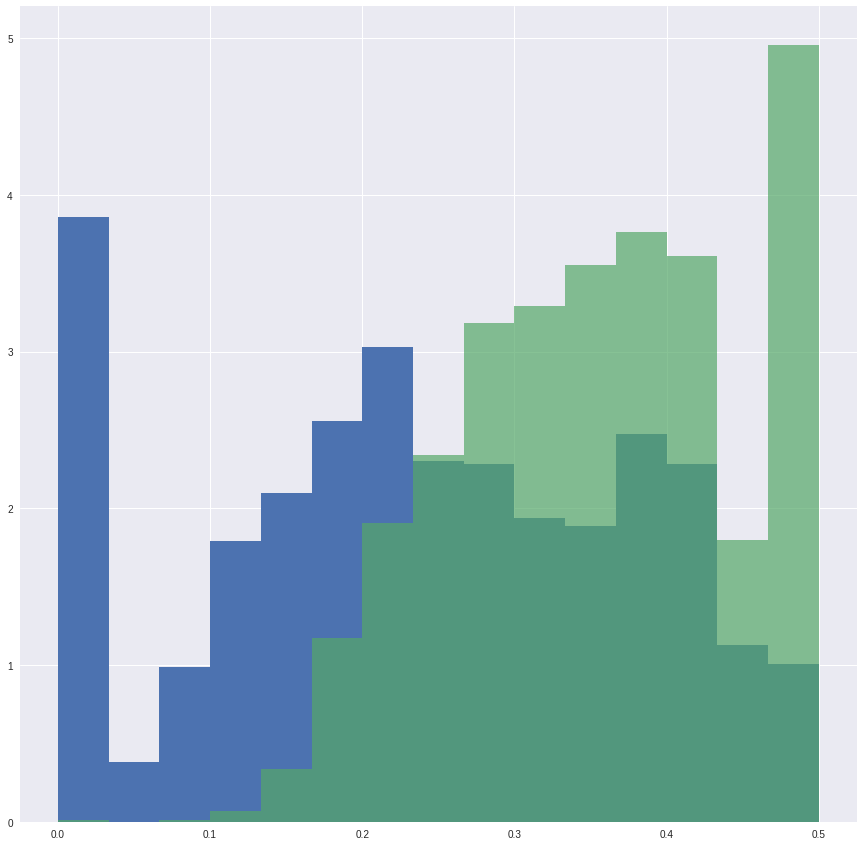

In [16]:
plt.hist(train.norm_sum_prob_weight_common_words[train['is_duplicate'] == 0], bins=15, normed=True, label='0')
plt.hist(train.norm_sum_prob_weight_common_words[train['is_duplicate'] == 1], bins=15, normed=True, label='1', alpha=0.7)
None

In [12]:
features_to_save = [
    'norm_sum_prob_weight_common_words'
]

In [13]:
import util
util.save_feature(train, 'train', features_to_save, 'id')
util.save_feature(test, 'test', features_to_save, 'test_id')